# $k$-simplex2vec: a simplicial extension of node2vec
In this notebook we show how to use the code for the $k$-simplex2vec algorithm presented in https://arxiv.org/abs/2010.05636. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec 
import gudhi
import scipy
import networkx as nx

import sklearn
from sklearn import cluster
from sklearn.decomposition import PCA

import gudhi
import k_simplex2vec as ks2v

%matplotlib inline 

### Building the simplicial complex: 
We start with a stochastic block model with three blocks of 20 nodes each, and given intra-block probability of connecting nodes p, and iter-block probability q for connecting nodes in different blocks. Then we fill in every complete subgraph on k+1 vertices by a k-simplex. 

In [2]:
## Build the graph
n=20 ## n nodes in each block 
q=0.3 
p=0.8
probs = [[p, q, q],[q, p, q],[q, q, p]] ## set probabilities for the blocks 
## first (0,n-1) are in the same block, (n,2n-1) in the second block, etc.. 

SBM = nx.generators.community.stochastic_block_model([n,n,n],probs, seed = 7)
 
## Build a simplicial complex from the graph
st = gudhi.SimplexTree() #Gudhi simplex tree --> structure to store the simplices
for edge in SBM.edges():
    st.insert(list(edge))
st.expansion(3) ## Fills in the clique complex up to dimension 3
simps_2= len(st.get_skeleton(2))-len(st.get_skeleton(1))
simps_3 = len(st.get_skeleton(3))-len(st.get_skeleton(3))

print('There are {} nodes, {} edges, {} triangles, and {} 3-simplices'.format(len(SBM.nodes),len(SBM.edges), simps_2,simps_3))                                                                 

There are 60 nodes, 795 edges, 3361 triangles, and 0 3-simplices


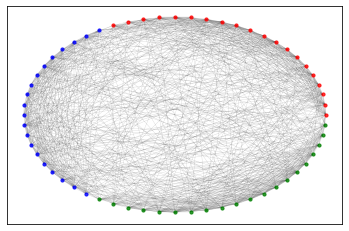

In [3]:
# Plot the graph
pos = nx.circular_layout(SBM)
nx.draw_networkx_nodes(SBM,pos,
                       nodelist=[i for i in range(n)],
                       node_color='r',
                       node_size=10,
                   alpha=0.8)
nx.draw_networkx_nodes(SBM,pos,
                       nodelist=[i for i in range(n,2*n)],
                       node_color='b',
                       node_size=10,
                   alpha=0.8)

nx.draw_networkx_nodes(SBM,pos,
                       nodelist=[i for i in range(2*n,3*n)],
                       node_color='g',
                       node_size=10,
                   alpha=0.8)
#edges
nx.draw_networkx_edges(SBM,pos,width=0.3,alpha=0.2)

### Performing the random walks and the  embeddings: 
1) We build a transition matrix P for the simplices of a given dimension k

2) Use the matrix P to do the random walks on the set of k-simplices

3) With the walks we obtain the representation of the k-simplices using word2vec

In [4]:
## build transition matrix for the edges 
p1 = ks2v.assemble(cplx =st, k= 1, scheme = "uniform", laziness =None)
P1 = p1.toarray()

Simplices = list()
for simplex in st.get_filtration():
    if simplex[1]!= np.inf:
        Simplices.append(simplex[0])
    else: 
        break  

In [ ]:
## Perform random walks on the edges
L = 20
N = 40
Walks = ks2v.RandomWalks(walk_length=L, number_walks=N, P=P1,seed = 3)
# to save the walks in a text file 
ks2v.save_random_walks(Walks,'RandomWalks_Edges.txt')

In [ ]:
## Embed the edges 
dim = 20
Emb = ks2v.Embedding(Walks = Walks, emb_dim = dim , epochs =5 ,filename ='k-simplex2vec_Edge_embedding.model')

### Visualization
We plot the embedding in two dimensions using PCA to reduce the dimension 

In [ ]:
#Emb = Word2Vec.load(emb_file)
Y=Emb.wv.vectors
pca=PCA(n_components=dim)
principalComponents = pca.fit_transform(Y)

Xax=principalComponents[:,0]
Yax=principalComponents[:,1]
Zax =  principalComponents[:,2]

fig,ax=plt.subplots(figsize=(10,7))
plt.scatter(Xax,Yax, s = 10)
plt.title('Projection of the Embedding of the edges in two dimensions')
ax.set_xlabel('PC1', fontsize = 15 )
ax.set_ylabel('PC2',fontsize = 15 )
plt.show()
